# ELECTRICITY PRODUCTION

### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
import plotly.express as px
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error


In [2]:
df = pd.read_csv("C:\\Users\\HP\\Downloads\\timeseries data\\Electric_Production.csv", date_format="DATE").set_index("DATE")

# df["DATE"] = df["DATE"].to_timestamp
df.index = pd.DatetimeIndex(df.index).to_period('M')
df.index.dtype

period[M]

In [3]:
timeseries = df["IPG2211A2N"]
timeseries.head()

DATE
1985-01    72.5052
1985-02    70.6720
1985-03    62.4502
1985-04    57.4714
1985-05    55.3151
Freq: M, Name: IPG2211A2N, dtype: float64

Text(1.0, 1.0, 'With increase in population through the years, \n more electricity is being produced to cater to this \n increasing population')

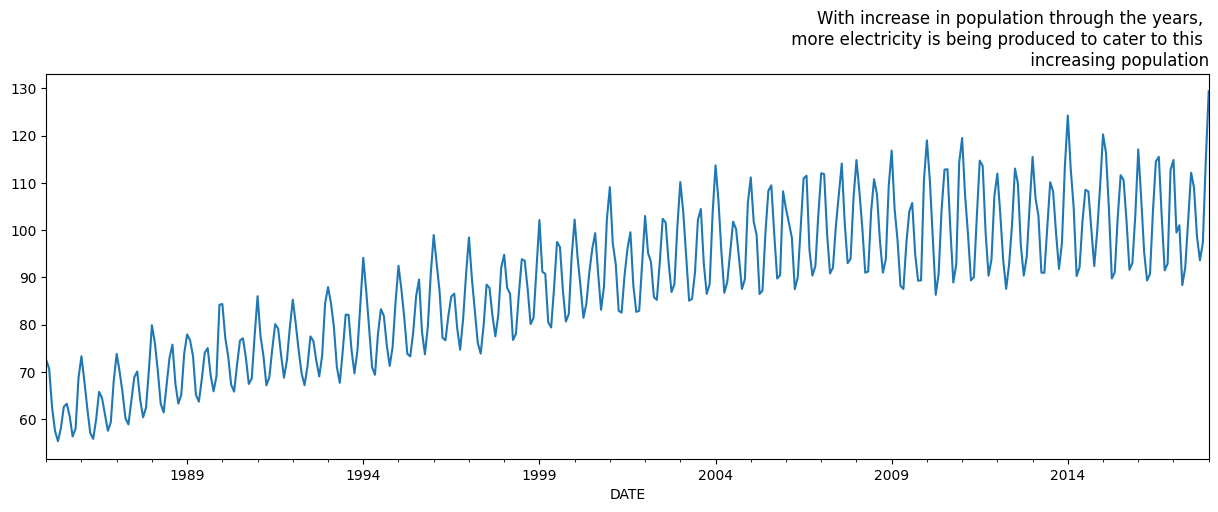

In [4]:
fig,ax=plt.subplots(figsize=(15,5))
timeseries.plot(kind="line",ax=ax);
plt.title("With increase in population through the years, \n more electricity is being produced to cater to this \n increasing population", loc = "right")

### Rolling average for yearly electricity production

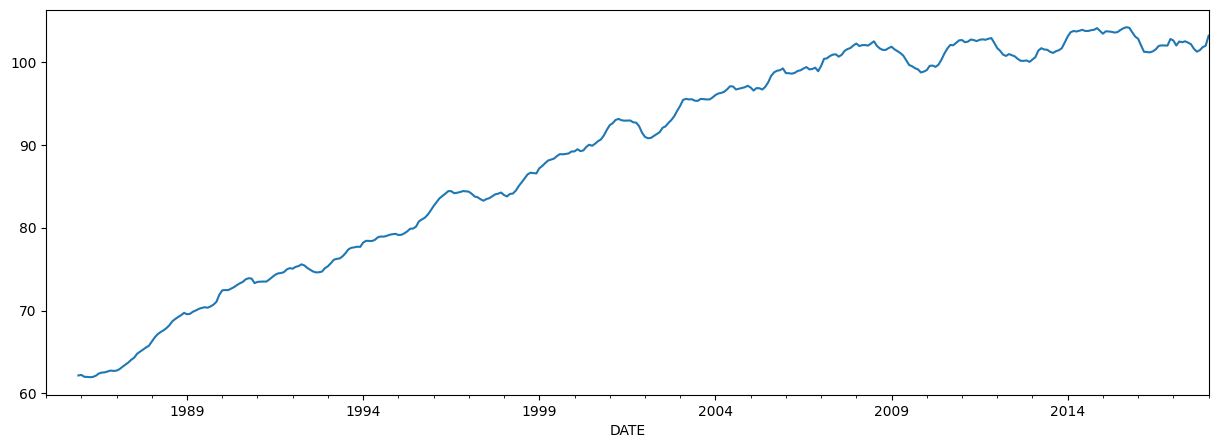

In [5]:
fig,ax=plt.subplots(figsize=(15,5))
timeseries.rolling(12).mean().plot(kind="line",ax=ax);

##### auto correlation plot

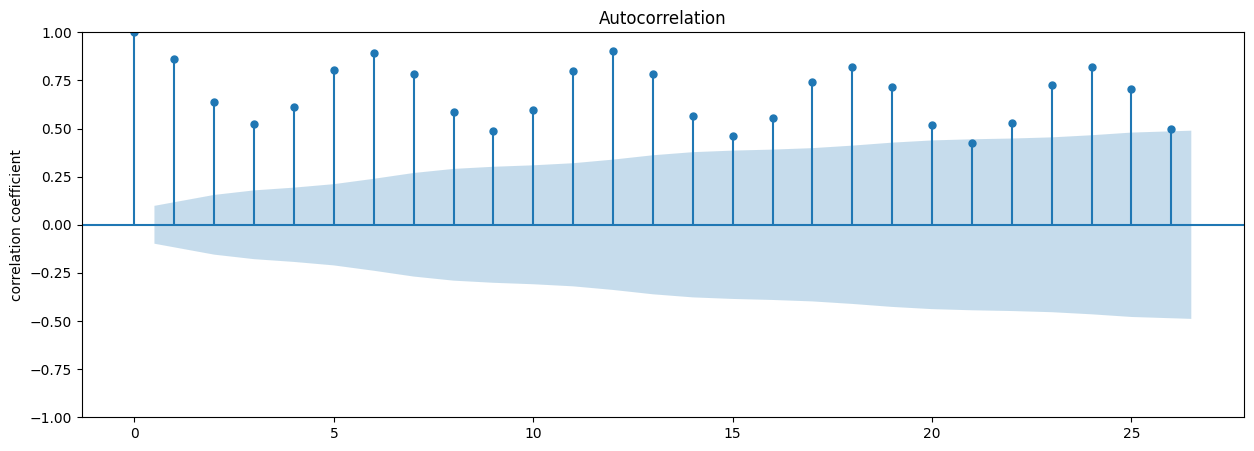

In [6]:
fig,ax=plt.subplots(figsize=(15,5))
plot_acf(timeseries, ax=ax)
plt.ylabel("correlation coefficient");

##### partial auto correlation plot

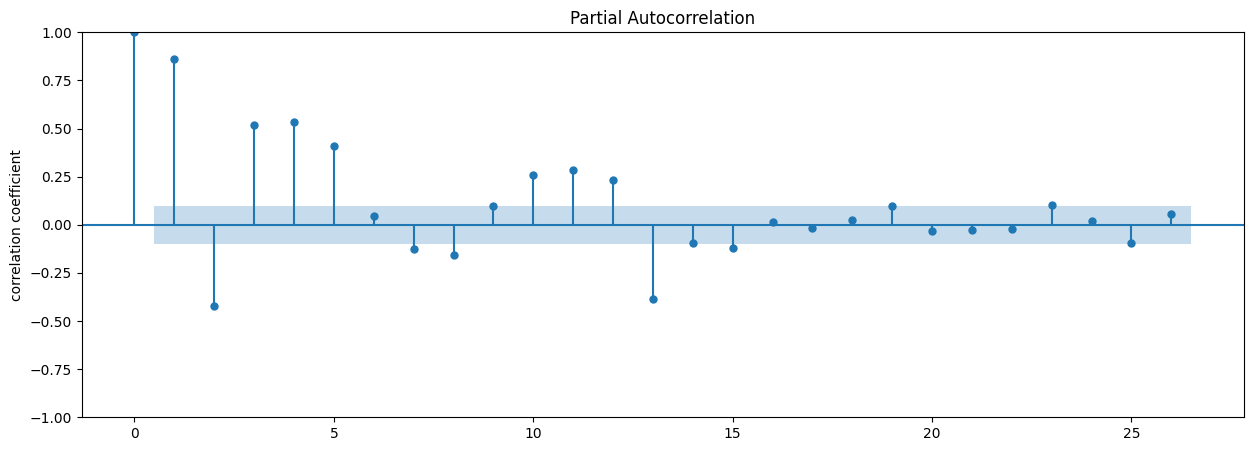

In [7]:
fig,ax=plt.subplots(figsize=(15,5))
plot_pacf(timeseries, ax=ax)
plt.ylabel("correlation coefficient");

#### Data Slicing

In [8]:
cutoff = int(0.85 * len(timeseries))
y_train =timeseries[:cutoff]
y_test =timeseries[cutoff:]

##### Baseline Model

In [9]:
baseline_pred = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train,baseline_pred)
print(f"the mean absolute error for the baseline model is {mae_baseline}")

the mean absolute error for the baseline model is 12.227437670491065


##### auto regression model

In [10]:
import time
maes = []
for p in range(1,31):
    start = time.time()
    model =AutoReg(y_train,lags=p).fit()
    predict = model.predict().dropna()
    end = time.time()
    mae = mean_absolute_error(predict,y_train[p:])
    print(f"the mean absolute error for lag: {p}, is {mae} @ {end-start} seconds")
    maes.append(mae)

mae_series = pd.Series(maes, name="mae", index = range(1,31))
mae_series.sort_values().head()



the mean absolute error for lag: 1, is 6.0855368485726915 @ 0.005983591079711914 seconds
the mean absolute error for lag: 2, is 5.218737238488474 @ 0.0039865970611572266 seconds
the mean absolute error for lag: 3, is 3.6632195137249077 @ 0.008811712265014648 seconds
the mean absolute error for lag: 4, is 3.1175601548100467 @ 0.004987478256225586 seconds
the mean absolute error for lag: 5, is 2.873897281226957 @ 0.006328105926513672 seconds
the mean absolute error for lag: 6, is 2.8724871766065387 @ 0.0059850215911865234 seconds
the mean absolute error for lag: 7, is 2.866974126315232 @ 0.005376338958740234 seconds
the mean absolute error for lag: 8, is 2.823446339318153 @ 0.003962993621826172 seconds
the mean absolute error for lag: 9, is 2.7832809930838627 @ 0.0015251636505126953 seconds
the mean absolute error for lag: 10, is 2.5138744389604697 @ 0.012969017028808594 seconds
the mean absolute error for lag: 11, is 2.160889311831358 @ 0.0039942264556884766 seconds
the mean absolute er

24    1.747704
27    1.749500
25    1.749536
26    1.751692
28    1.752513
Name: mae, dtype: float64

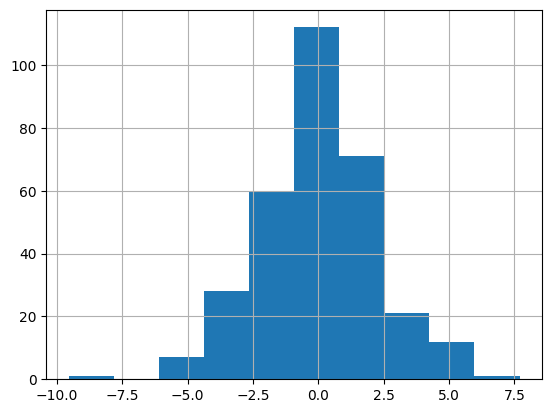

In [11]:
model = AutoReg(y_train,lags=24).fit()
residual = model.resid
#visualize the residual values using histogram 
residual.hist();

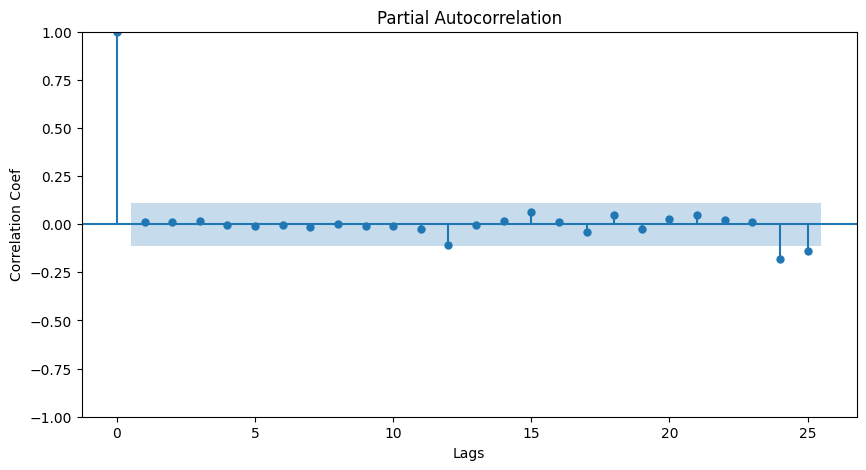

In [12]:
fig, ax = plt.subplots(figsize = (10,5))
plot_pacf(residual, ax=ax)
plt.ylabel("Correlation Coef")
plt.xlabel("Lags");

In [13]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
print(mean_absolute_error(y_pred_test,y_test))


df_pred_test = pd.DataFrame(
    {"y_test":y_test, "y_pred":y_pred_test}
)

3.487219556933896


In [14]:
# assign a copy of df_pred_test to plot
plot = df_pred_test

# Convert the index of plot to string type to make it compatible with Plotly
plot.index = plot.index.astype("str")
fig = px.line(plot, labels={"values":"kk"})
fig.show()

#### walk forward validation(autoreg)

In [15]:
train = y_train.copy()
predictions = pd.Series()
for i in range(len(y_test)):
    model = AutoReg(train, lags=24).fit()
    next_pred = model.forecast()
    train = pd.concat([train,y_test[next_pred.index]])
    predictions = pd.concat([predictions,next_pred])
predictions.head()
print(mean_absolute_error(predictions,y_test))



C:\Users\HP\AppData\Local\Temp\ipykernel_5492\1482246654.py:7: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



2.8940031273664233


In [16]:
df_pred_test_wfv = pd.DataFrame(
    {"y_test":y_test, "y_pred": predictions}
)
df_pred_test_wfv.head()

,y_test,y_pred
2013-02,106.7340,108.718030
2013-03,102.9948,96.017562
2013-04,91.0092,93.740078
2013-05,90.9634,93.496260
2013-06,100.6957,102.852175


In [26]:
# assign a copy of df_pred_test to plot
plot_wfv = df_pred_test_wfv

# Convert the index of plot to string type to make it compatible with Plotly
plot_wfv.index = plot_wfv.index.astype("str")
fig = px.line(plot_wfv, labels={"value":"Electricity Production"})
fig.show()

#### arima

In [18]:
p_params = range(0,25,8)
q_params = range(0,3,1)
# Create a copy of y_train to use as a history for predictions
history = y_train.copy()

# Create an empty Series to store the predictions
predictions_arma = pd.Series()

for p in p_params:
    for q in q_params:
        start = time.time()
        model = ARIMA(history, order=(p,0,q)).fit()
        y_pred_arima = model.predict()
        end = time.time()
        time_elapsed = end -start
        mae_arima = mean_absolute_error(y_train, y_pred_arima)
        print(f"The mae for ({p},0,{q}) is {mae_arima} @ {time_elapsed} seconds)");

The mae for (0,0,0) is 12.227437965931223 @ 0.11507654190063477 seconds)
The mae for (0,0,1) is 7.215948465305339 @ 0.08527159690856934 seconds)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



The mae for (0,0,2) is 5.485134155370704 @ 0.3610823154449463 seconds)
The mae for (8,0,0) is 2.8813875174909445 @ 0.6533594131469727 seconds)
The mae for (8,0,1) is 2.8772982494251615 @ 1.0218336582183838 seconds)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



The mae for (8,0,2) is 2.8190535300769977 @ 1.9370293617248535 seconds)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



The mae for (16,0,0) is 1.9396561147700562 @ 4.016454219818115 seconds)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



The mae for (16,0,1) is 1.9883621232053947 @ 4.446259498596191 seconds)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



The mae for (16,0,2) is 1.968255455753226 @ 4.4421226978302 seconds)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



The mae for (24,0,0) is 1.934318929862132 @ 11.33798861503601 seconds)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



The mae for (24,0,1) is 1.9473329251020361 @ 10.495906114578247 seconds)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



The mae for (24,0,2) is 1.8812809295984523 @ 9.068525314331055 seconds)


In [19]:
best_model_arima = ARIMA(y_train, order=(16,0,0)).fit()
prediction_arima = best_model_arima.predict()
print(mean_absolute_error(prediction_arima,y_train))

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



1.9396561147700562


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



####  walk forward validation (ARIMA)


In [22]:
train = y_train.copy()
predictions = pd.Series()
for i in range(len(y_test)):
    model = ARIMA(train, order=(16,0,0)).fit()
    next_pred = model.forecast()
    train = pd.concat([train,y_test[next_pred.index]])
    predictions = pd.concat([predictions,next_pred])
predictions.head()


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\HP\AppData\Local\Temp\ipykernel_5492\1404156357.py:7: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\HP\AppData\Local\Programs\P

2013-02    107.458541
2013-03     94.567002
2013-04     94.125921
2013-05     94.336827
2013-06    102.671366
Freq: M, dtype: float64

In [21]:
print(mean_absolute_error(predictions,y_test))

2.819085877016359


In [23]:
df_arma_test_wfv = pd.DataFrame({"y_test": y_test, "y_pred":predictions}, index=y_test.index)

In [27]:
# assign a copy of df_pred_test to plot
plot_wfv = df_arma_test_wfv

# Convert the index of plot to string type to make it compatible with Plotly
plot_wfv.index = plot_wfv.index.astype("str")
fig = px.line(plot_wfv, labels={"value":"Electricity Production"})
fig.show()